## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-08-05 03:38:47.192 | INFO     |  Running on cpu


In [3]:
task = 'BlockTableBlue'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

2025-08-05 03:38:54.630 | INFO     |  Loading dataset(s): 
2025-08-05 03:38:54.631 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/BlockTableBlue/demos/metadata.json
2025-08-05 03:38:54.637 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-08-05 03:38:54.637 | INFO     |    Extracted tsdf object labels []
2025-08-05 03:38:54.637 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=

In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([162, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([162]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([162, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([162, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([162, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([162, 3, 256, 256]), device=cpu, dt

In [6]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=10,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=1,
    min_end_distance=20,
    velocity_threshold=0.002,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-05 03:39:08.796 | INFO     |  Fitting AutoTPGMM
2025-08-05 03:39:08.796 | INFO     |  Performing fitting actions: [INIT]
2025-08-05 03:39:08.797 | INFO     |  Segmenting trajectories


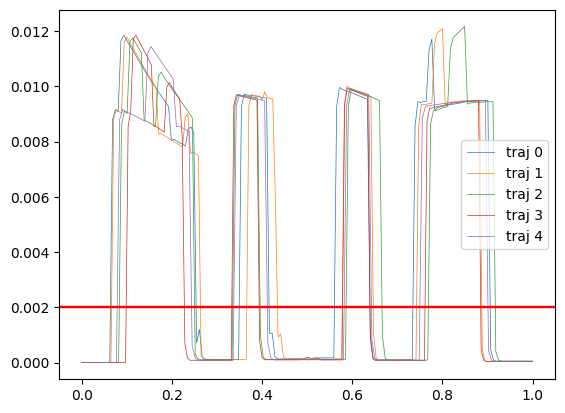

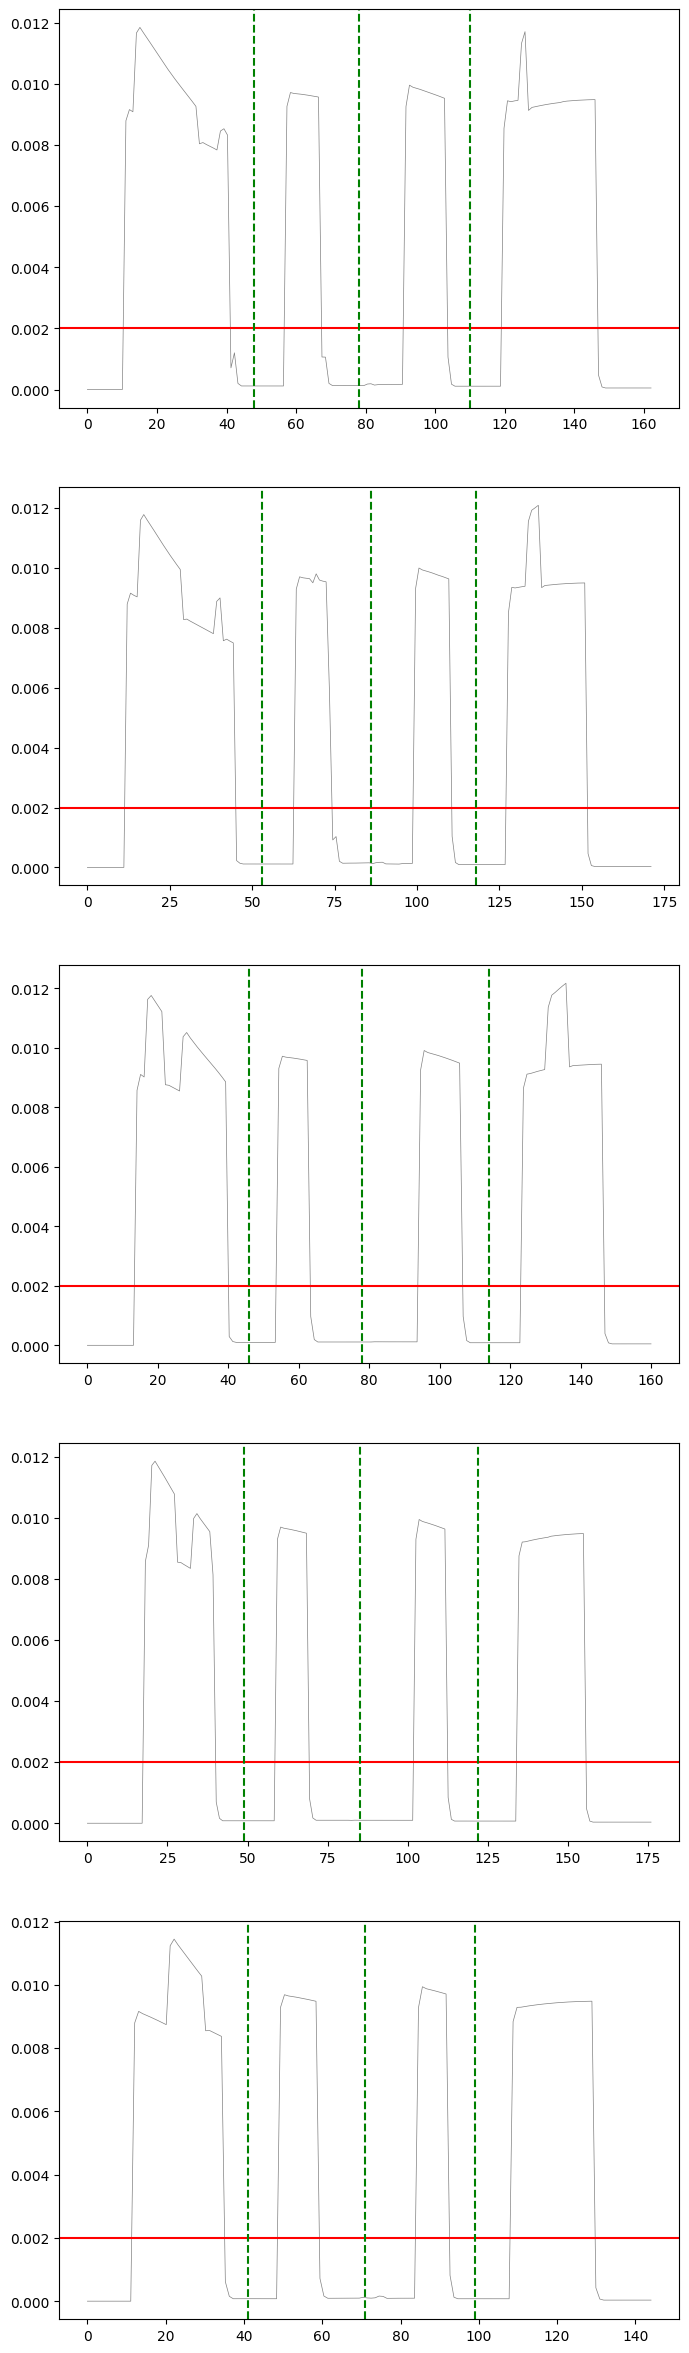

2025-08-05 03:39:10.667 | INFO     |  Creating segement of demos.
2025-08-05 03:39:10.678 | INFO     |  Subsampling to length 56 using strategy mean-length.
2025-08-05 03:39:10.680 | INFO     |  Creating segement of demos.
2025-08-05 03:39:10.695 | INFO     |  Subsampling to length 41 using strategy mean-length.
2025-08-05 03:39:10.697 | INFO     |  Creating segement of demos.
2025-08-05 03:39:10.707 | INFO     |  Subsampling to length 42 using strategy mean-length.
2025-08-05 03:39:10.709 | INFO     |  Creating segement of demos.
2025-08-05 03:39:10.718 | INFO     |  Subsampling to length 59 using strategy mean-length.
2025-08-05 03:39:10.720 | INFO     |  ... created 4 segments
2025-08-05 03:39:10.721 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:39:10.721 | INFO     |    Creating partial frame view of demos.
2025-08-05 03:39:10.730 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-08-05 03:39:10.730 | INFO     |    Changing number of components to 2
2025-08-05 03:39:

Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:11.148 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:39:11.148 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:11.483 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:39:11.483 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:11.743 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:39:11.745 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:12.031 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:39:12.032 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:12.322 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:39:12.323 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:12.642 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:39:12.643 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:12.945 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:39:12.946 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:13.347 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:39:13.348 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:13.686 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:39:13.686 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:13.981 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-08-05 03:39:13.982 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-08-05 03:39:13.982 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-08-05 03:39:13.983 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-08-05 03:39:13.983 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-08-05 03:39:13.983 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-08-05 03:39:13.983 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-08-05 03:39:13.983 | INFO     |  obj006     score (rel):     -0 (0.008)
2025-08-05 03:39:13.983 | INFO     |  obj007     score (rel):     -0 (0.835)
2025-08-05 03:39:13.984 | INFO     |  obj008     score (rel):     -0 (0.005)
2025-08-05 03:39:13.985 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:39:14.057 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:39:14.058 | INFO     |    Creating partial frame view of demos.
2025-08

Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:14.246 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:39:14.247 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:14.461 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:39:14.462 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:14.667 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:39:14.668 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:15.055 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:39:15.059 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:15.323 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:39:15.324 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:15.556 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:39:15.557 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:15.781 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:39:15.782 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:15.979 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:39:15.981 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:16.180 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:39:16.180 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:16.495 | INFO     |  ee_init    score (rel):     -0 (0.184)
2025-08-05 03:39:16.498 | INFO     |  obj000     score (rel):     -0 (0.184)
2025-08-05 03:39:16.499 | INFO     |  obj001     score (rel):     -0 (0.184)
2025-08-05 03:39:16.499 | INFO     |  obj002     score (rel):     -0 (0.184)
2025-08-05 03:39:16.499 | INFO     |  obj003     score (rel):     -0 (0.184)
2025-08-05 03:39:16.499 | INFO     |  obj004     score (rel):     -0 (0.184)
2025-08-05 03:39:16.499 | INFO     |  obj005     score (rel):     -0 (0.184)
2025-08-05 03:39:16.499 | INFO     |  obj006     score (rel):     -0 (0.001)
2025-08-05 03:39:16.500 | INFO     |  obj007     score (rel):     -0 (1.000)
2025-08-05 03:39:16.500 | INFO     |  obj008     score (rel):     -0 (0.002)
2025-08-05 03:39:16.501 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:39:16.507 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:39:16.508 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:16.784 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:39:16.786 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:17.067 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:39:17.068 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:17.348 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:39:17.348 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:17.688 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:39:17.688 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:17.940 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:39:17.940 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:18.192 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:39:18.193 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:18.410 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:39:18.412 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:18.770 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:39:18.772 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:19.024 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:39:19.025 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:39:19.210 | INFO     |  ee_init    score (rel):     -0 (0.193)
2025-08-05 03:39:19.211 | INFO     |  obj000     score (rel):     -0 (0.193)
2025-08-05 03:39:19.211 | INFO     |  obj001     score (rel):     -0 (0.193)
2025-08-05 03:39:19.212 | INFO     |  obj002     score (rel):     -0 (0.193)
2025-08-05 03:39:19.212 | INFO     |  obj003     score (rel):     -0 (0.193)
2025-08-05 03:39:19.212 | INFO     |  obj004     score (rel):     -0 (0.193)
2025-08-05 03:39:19.212 | INFO     |  obj005     score (rel):     -0 (0.193)
2025-08-05 03:39:19.212 | INFO     |  obj008     score (rel):     -0 (0.001)
2025-08-05 03:39:19.213 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:39:19.217 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:39:19.218 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:19.500 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:39:19.501 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:19.847 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:39:19.847 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:20.221 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:39:20.222 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:20.582 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:39:20.583 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:20.893 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:39:20.894 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:21.163 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:39:21.164 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:21.469 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:39:21.470 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:21.737 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:39:21.739 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:22.089 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:39:22.090 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:39:22.514 | INFO     |  ee_init    score (rel):     -0 (0.350)
2025-08-05 03:39:22.514 | INFO     |  obj000     score (rel):     -0 (0.350)
2025-08-05 03:39:22.514 | INFO     |  obj001     score (rel):     -0 (0.350)
2025-08-05 03:39:22.514 | INFO     |  obj002     score (rel):     -0 (0.350)
2025-08-05 03:39:22.515 | INFO     |  obj003     score (rel):     -0 (0.350)
2025-08-05 03:39:22.515 | INFO     |  obj004     score (rel):     -0 (0.350)
2025-08-05 03:39:22.515 | INFO     |  obj005     score (rel):     -0 (0.350)
2025-08-05 03:39:22.515 | INFO     |  obj006     score (rel):     -0 (0.005)
2025-08-05 03:39:22.515 | INFO     |  obj008     score (rel):     -0 (0.003)
2025-08-05 03:39:22.516 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:39:22.518 | INFO     |  Segmented trajs into 4 segments
2025-08-05 03:39:22.562 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.139505 -0.139505 -

Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:39:22.612 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1
2025-08-05 03:39:22.617 | INFO     |  Changing number of components to 3


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[3.28e+061, 3.28e+061, 3.16e+061, 2.94e+061, 2.64e+061, 2.28e+061,
          1.91e+061, 1.54e+061, 1.19e+061, 8.93e+060, 6.46e+060, 4.50e+060,
          1.90e+060, 2.12e+059, 6.41e+057, 6.01e+055, 7.21e+052, 1.14e+049,
          2.56e+044, 9.16e+038, 5.67e+032, 6.64e+025, 1.60e+018, 8.61e+009,
          1.11e+001, 3.69e-009, 3.35e-019, 8.87e-030, 5.43e-052, 5.39e-064,
          2.03e-076, 3.15e-089, 6.07e-095, 1.36e-100, 1.33e-106, 6.03e-113,
          1.29e-119, 1.34e-126, 2.72e-140, 1.43e-154, 5.35e-169, 1.67e-168,
          3.56e-167, 1.67e-167, 5.45e-168, 1.71e-168, 5.20e-169, 9.89e-170,
          1.82e-170, 3.21e-171, 5.48e-172, 9.03e-173, 1.43e-173, 2.20e-174,
          3.25e-175, 4.63e-176, 1.95e+061, 1.95e+061, 1.88e+061, 1.75e+061,
          1.57e+061, 1.36e+061, 1.14e+061, 9.14e+060, 7.10e+060, 5.32e+060,
          3.85e+060, 2.68e+060, 7.67e+059, 5.72e+058, 1.08e+055, 2.39e+052,
          7.24e+048, 3.03e+044, 1.88e+039, 1.95e+033, 3.67e+026, 1.36e+019,
          1.

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-05 03:39:25.949 | INFO     |  Did not specify time_based, deciding automatically.
2025-08-05 03:39:26.308 | WARNING  |  Skippig NaN Gaussians.


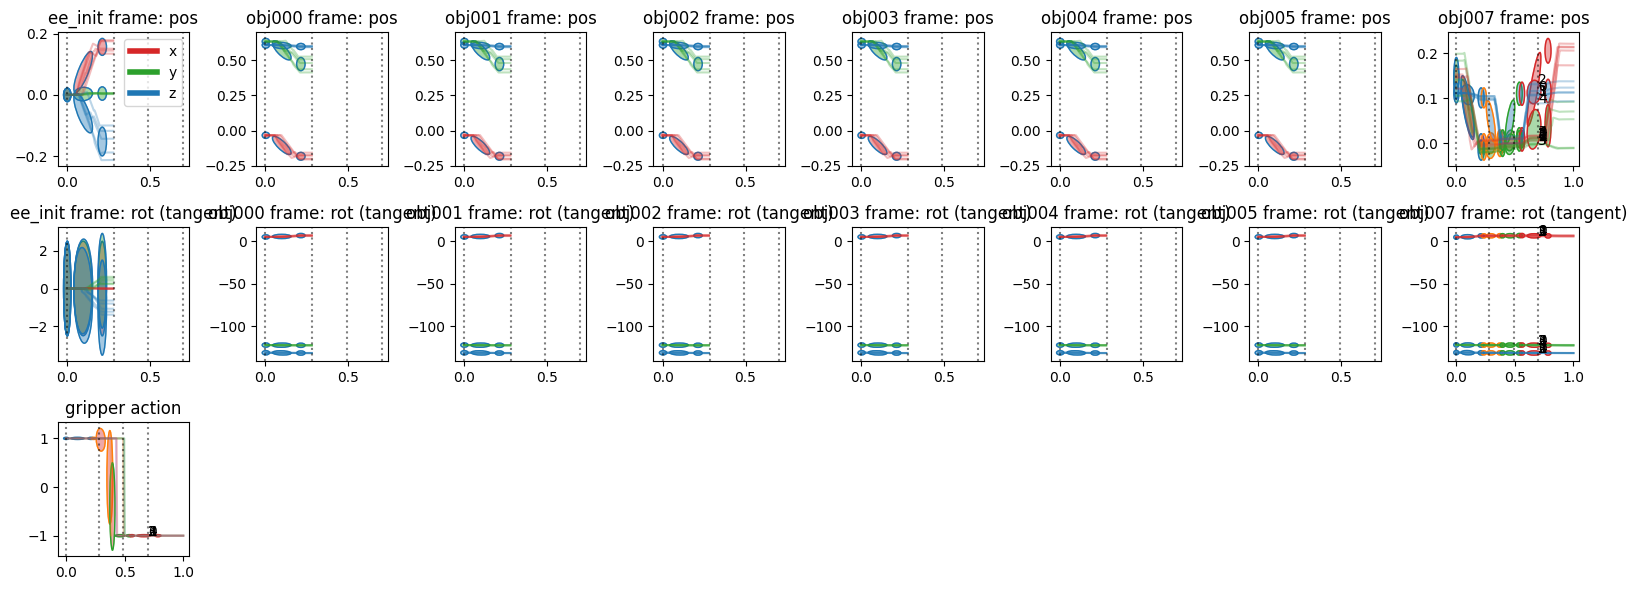

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-05 03:39:31.766 | INFO     |  Fitting AutoTPGMM
2025-08-05 03:39:31.769 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:39:31.817 | INFO     |  HMM EM ...
2025-08-05 03:39:31.857 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-05 03:39:32.182 | INFO     |  HMM init priors not defined, initializing to uniform
2025-08-05 03:39:39.177 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[5.97e-011, 1.03e-011, 1.55e-012, 2.04e-013, 2.32e-014, 2.25e-015,
          1.84e-016, 1.26e-017, 7.08e-019, 3.25e-020, 1.21e-021, 3.53e-023,
          4.18e-025, 5.82e-028, 2.82e-032, 9.93e-039, 3.32e-048, 1.47e-061,
          1.27e-079, 3.59e-103, 5.96e-133, 1.13e-169, 5.22e-214, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 7.13e-011, 1.43e-011, 2.59e-012, 4.14e-013,
          5.83e-014, 7.11e-015, 7.47e-016, 6.66e-017, 4.99e-018, 3.11e-019,
          1.59e-020, 6.51e-022, 8.14e-024, 8.83e-027, 2.76e-033, 1.52e-042,
          2.03e-055, 9.67e-073, 2.53e-095, 6.31e-124, 2.83e-159, 4.63e-202,
          6.

2025-08-05 03:39:49.895 | INFO     |  Did not specify time_based, deciding automatically.


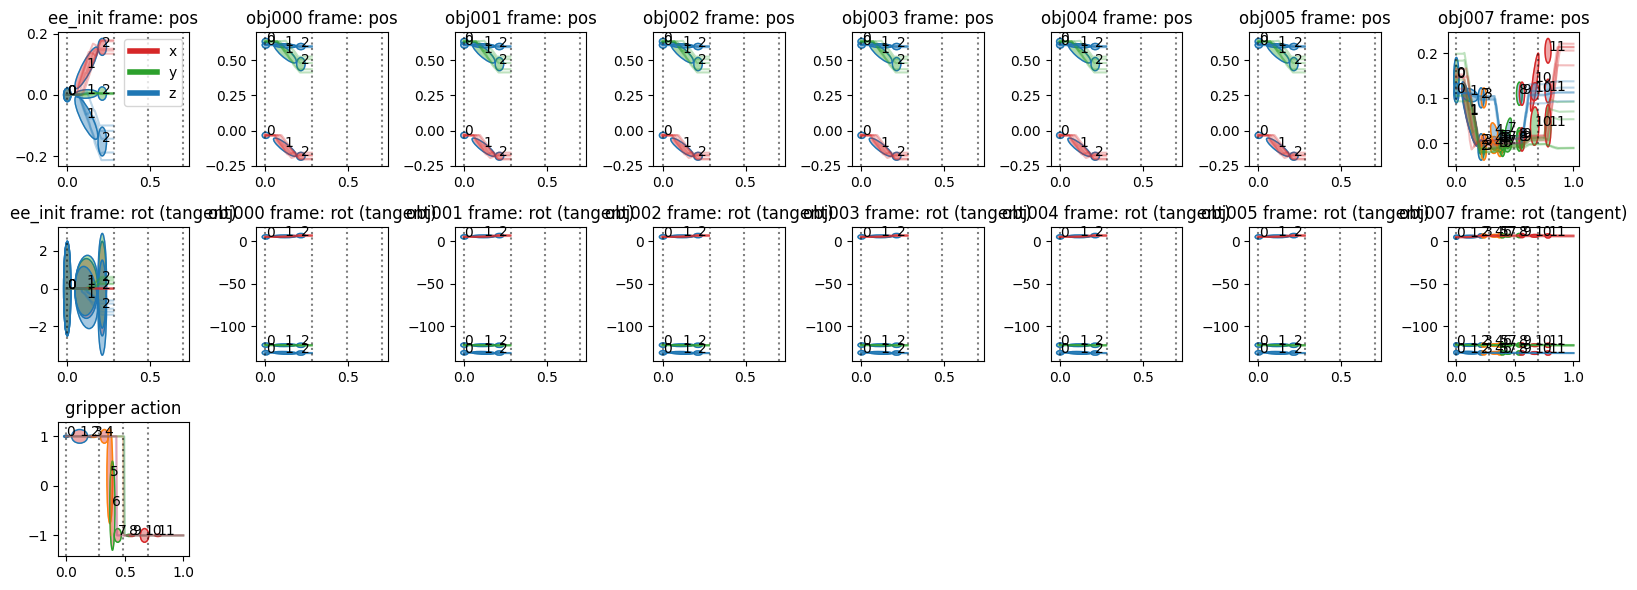

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

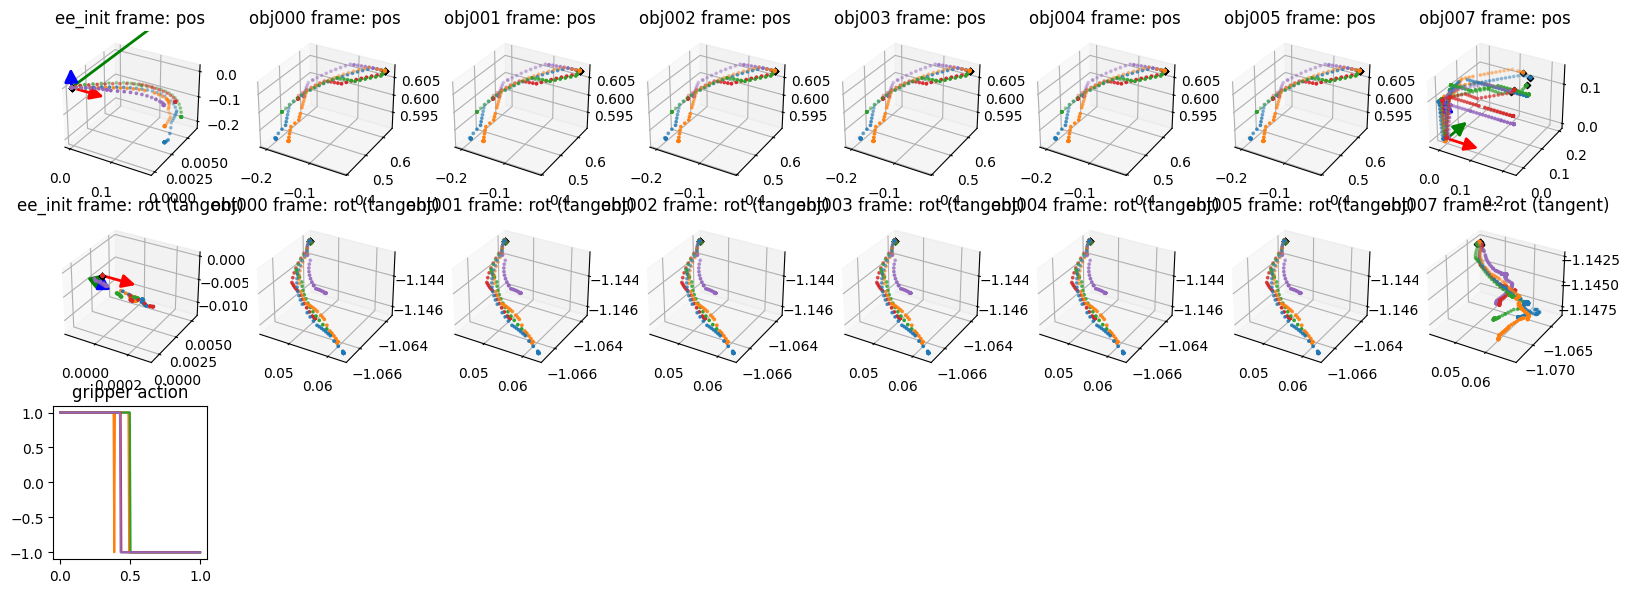

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

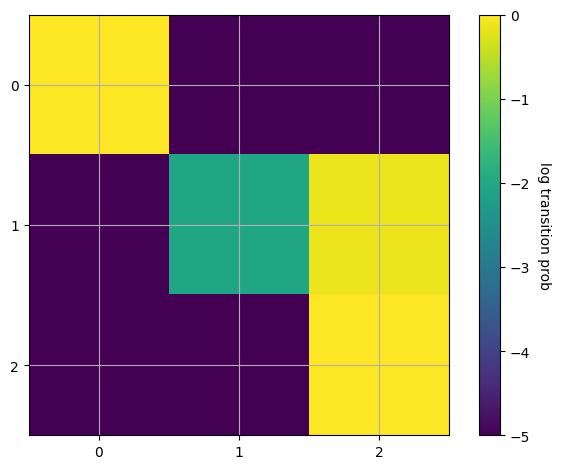

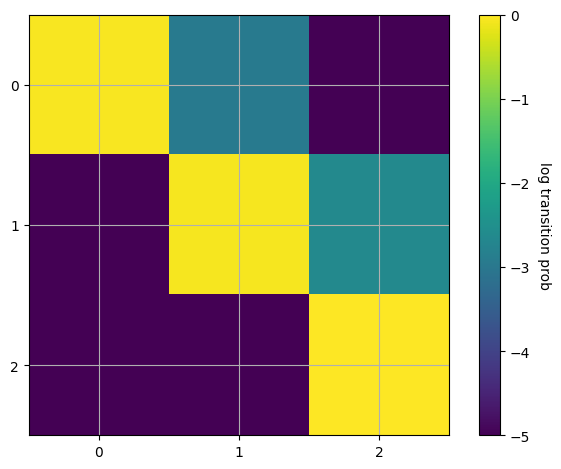

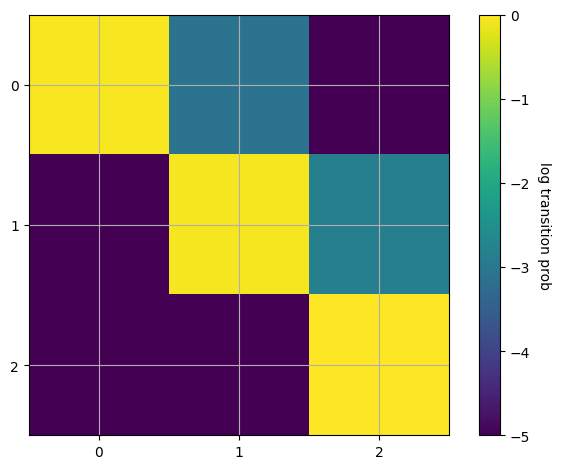

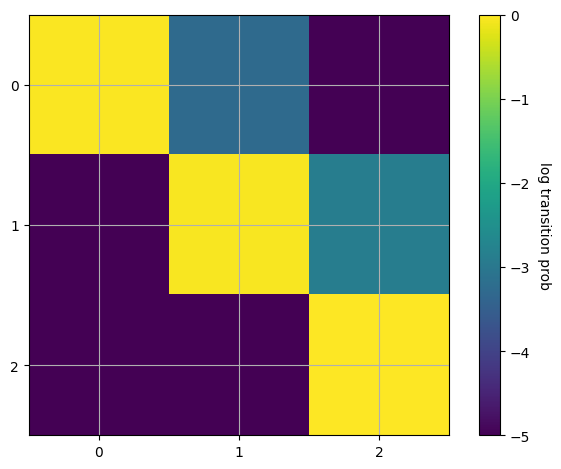

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-08-05 03:40:06.702 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-08-05 03:40:07.040 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-08-05 03:40:07.154 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[1.]]), array([[1.]]))
2025-08-05 03:40:07.155 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:40:07.268 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:40:08.345 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:40:08.435 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:40:08.542 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:40:08.634 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

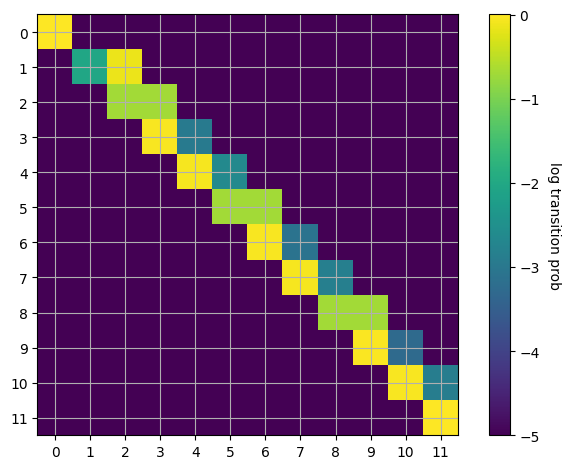

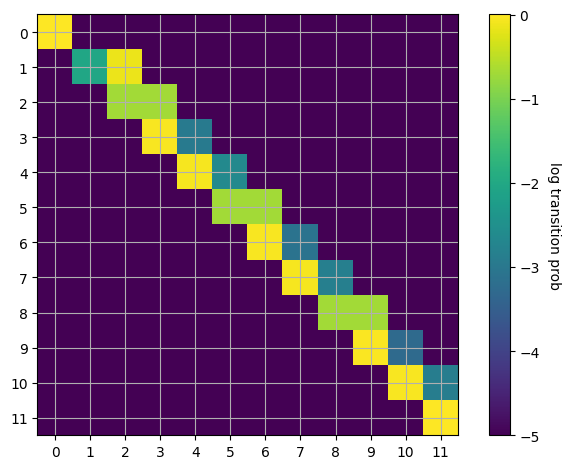

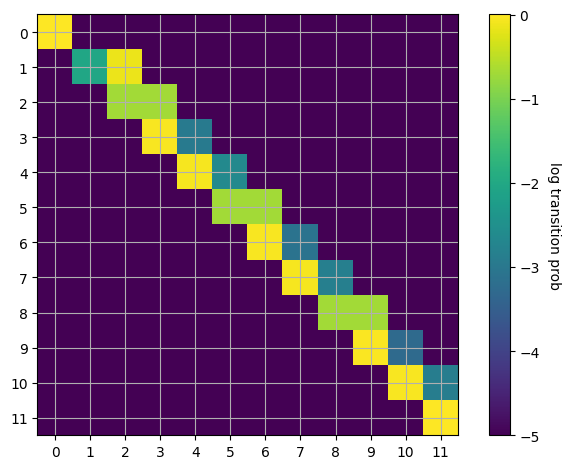

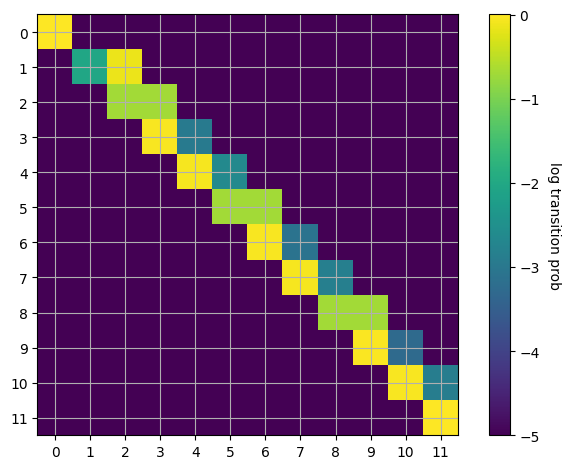

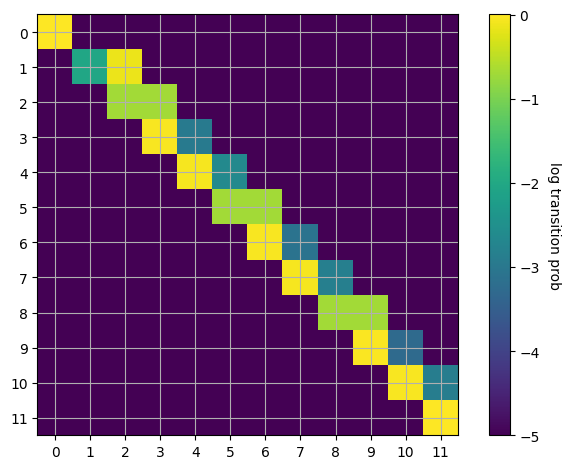

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-08-05 03:40:23.302 | INFO     |  Taking frame origins from demos.


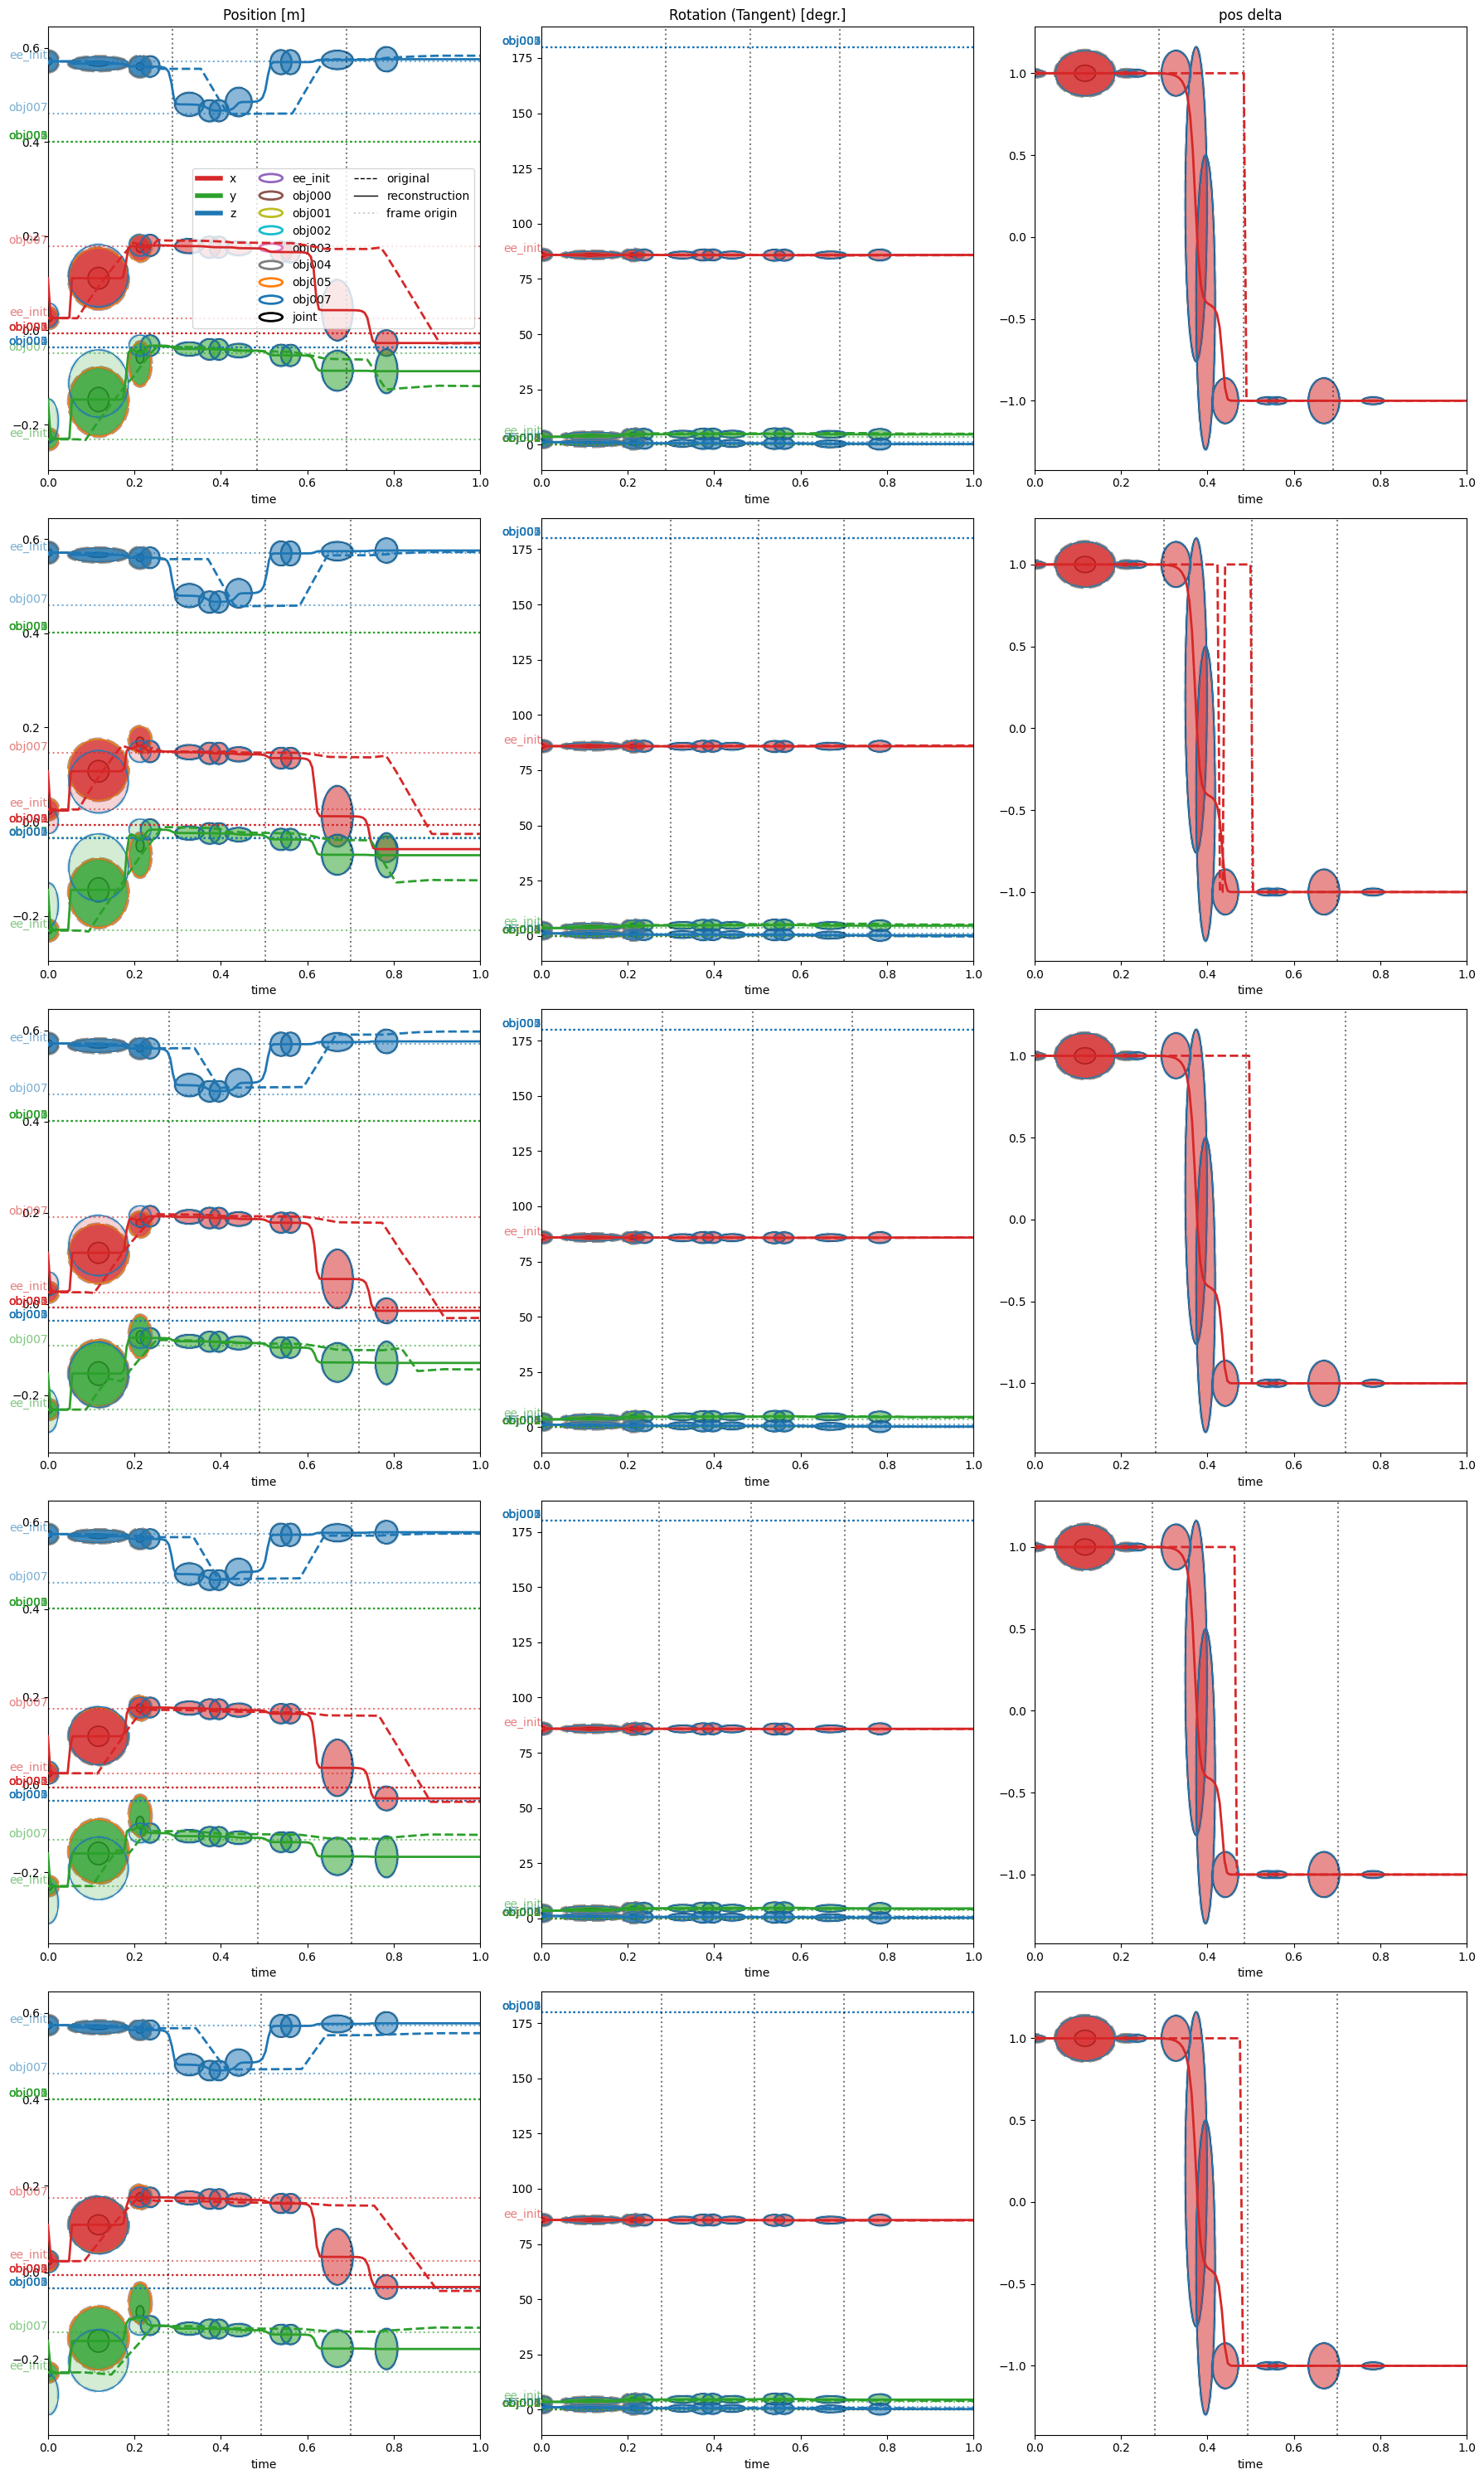

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range

: 